In [67]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

## Set up parameters, create isochrone grid

In [68]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [69]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [70]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [71]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Generate isochrones using parameter and age arrays

In [72]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [73]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


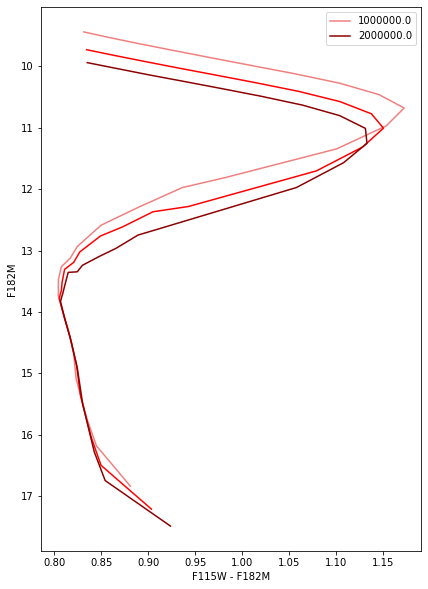

In [74]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [75]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [76]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
count = 0
for i in range(len(companions)):
    if companions[i] is None:
        count = count + 1
        continue
    print(companions[i])

print(count)
print(len(companions))


[0.12153727093424861, 3118.301, 3.495, 13.363, 12.469]
[0.06019233544810485, 2942.101, 3.468, 14.056, 13.239]
[0.011202177535168412, 2755.75, 3.668, 15.876, 15.05]
[0.15809555865664315, 3254.883, 3.583, 13.156, 12.189]
[0.01127626036608013, 2756.879, 3.668, 15.868, 15.043]
[0.003961676267032335, 2564.883, 3.712, 16.974, 16.133]
[0.026845305566327644, 2864.352, 3.562, 14.92, 14.109]
[0.08431710152249491, 3006.782, 3.465, 13.714, 12.873]
[0.6934938688488899, 3976.227, 3.754, 11.831, 10.706]
[0.14277998907400472, 3219.394, 3.572, 13.228, 12.283]
[0.04122421096151292, 2911.427, 3.504, 14.461, 13.654]
[0.12796463074872982, 3132.309, 3.493, 13.309, 12.408]
[0.005391632436506626, 2621.496, 3.707, 16.682, 15.846]
[0.1186926365897145, 3112.101, 3.496, 13.386, 12.496]
[0.20550916809771047, 3364.751, 3.617, 12.931, 11.896]
[0.0238784254236589, 2849.137, 3.579, 15.055, 14.241]
[0.002125519374540978, 2389.992, 3.693, 17.712, 16.836]
[0.058738015682946544, 2933.621, 3.463, 14.081, 13.266]
[0.0060672

# Determine mass ratios of binaries

(array([  3.,  14.,  69., 121., 181., 124., 134., 141., 120., 132.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

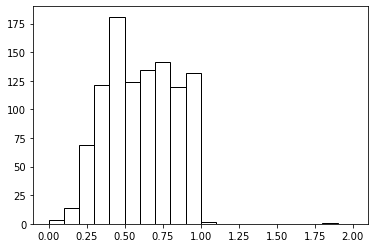

In [77]:
# mass ratios pre-filtering
ratios = []
for i in range(len(compMasses)):
    ratios.append(compMasses[i] / masses[i + first_binary])
    # print(ratios[i])

py.hist(ratios, bins=20, range=[0,2], fill=False)

(array([  1.,  14.,  64., 116., 168., 123., 127., 134., 117., 128.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

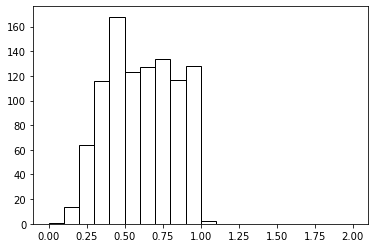

In [78]:
# mass ratios post-filtering
new_ratios = []
for i in range(len(companions)):
    if companions[i] is None:
        continue
    new_ratios.append(compMasses[i] / masses[i + first_binary])
    
py.hist(new_ratios, bins=20, range=[0,2], fill=False)

(array([ 3.,  0.,  7., 10., 17.,  6., 10., 11.,  3.,  5.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

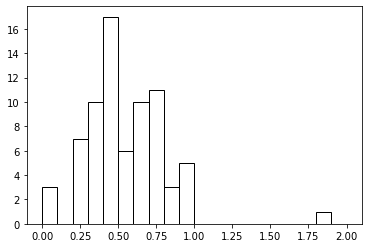

In [79]:
# mass ratios of binaries with primary over 1 Msun pre-filtering
gt1m_ratios = []
for i in range(len(companions)):
    if masses[i + first_binary] > 1:
        gt1m_ratios.append(compMasses[i] / masses[i + first_binary])

# print(len(gt1m_ratios))
py.hist(gt1m_ratios, bins=20, range=[0,2], fill=False)

(array([1., 0., 2., 5., 4., 5., 3., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

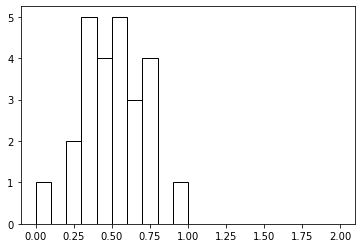

In [80]:
# mass ratios of binaries with primary over 1 Msun post-filtering
gt1m_ratios_filtered = []
for i in range(len(companions)):
    if masses[i + first_binary] > 1 and companions[i] is not None:
        gt1m_ratios_filtered.append(compMasses[i] / masses[i + first_binary])
    
# print(len(gt1m_ratios_filtered))
py.hist(gt1m_ratios_filtered, bins=20, range=[0,2], fill=False)

# Superimpose primary stars and companion stars against isochrones separately

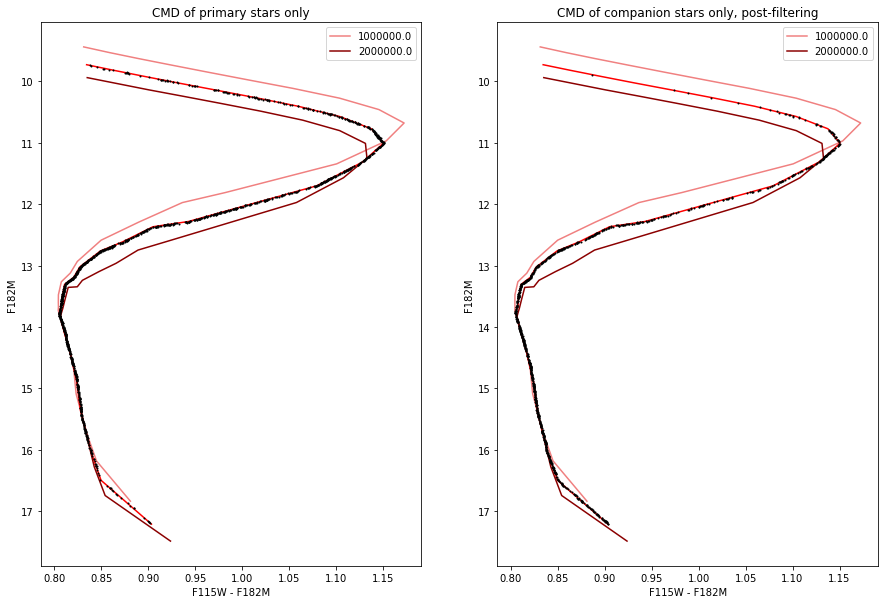

In [81]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of primary stars only')
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of companion stars only, post-filtering')
py.legend()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [82]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

flux_ratios = []

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    flux_ratios.append(flux21 / flux11)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

(array([ 1., 18., 42., 53., 45., 68., 75., 61., 72., 65., 41., 58., 54.,
        45., 56., 36., 54., 44., 51., 53.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 <BarContainer object of 30 artists>)

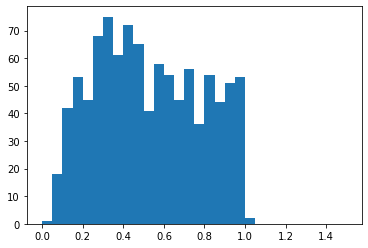

In [83]:
py.hist(flux_ratios, bins=30, range=[0,1.5])

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

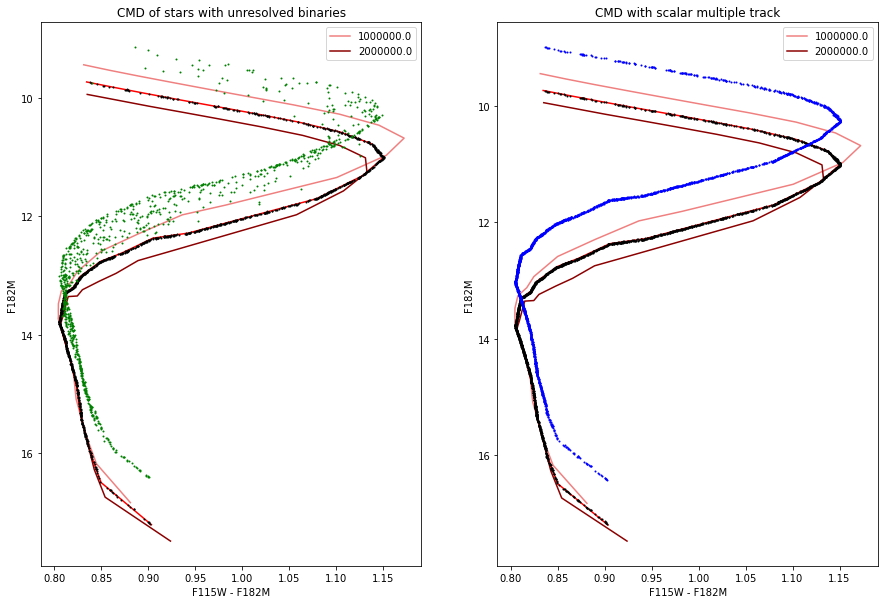

In [84]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of stars with unresolved binaries')
py.legend()

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='green')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    # x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    # py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot primary stars
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
# plot magnitude of each star if its flux was double
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD with scalar multiple track')
py.legend()

# Test CMD generation with different mass ratios

In [95]:
forced_mass_ratios1p0 = []
forced_mass_ratios0p5 = []
forced_mass_ratios0p1 = []

for i in range(len(companions)):
    forced_mass_ratios1p0.append(masses[first_binary + i])
    forced_mass_ratios0p5.append(masses[first_binary + i] * 0.5)
    forced_mass_ratios0p1.append(masses[first_binary + i] * 0.1)
    
# perform interpolation on companion stars
companions1p0 = np.empty(len(compMasses), dtype=object)
companions0p5 = np.empty(len(compMasses), dtype=object)
companions0p1 = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions1p0[i] = interpolator.interpolate(level_ages_myr[i + first_binary], forced_mass_ratios1p0[i], instances, 
                                                log_age_arr, filters)
    companions0p5[i] = interpolator.interpolate(level_ages_myr[i + first_binary], forced_mass_ratios0p5[i], instances, 
                                                log_age_arr, filters)
    companions0p1[i] = interpolator.interpolate(level_ages_myr[i + first_binary], forced_mass_ratios0p1[i], instances, 
                                                log_age_arr, filters)

In [96]:
unresolved_binaries1p0 = []
unresolved_binaries0p5 = []
unresolved_binaries0p1 = []

for i in range(len(companions1p0)):
    if stars[i + first_binary] is None or companions1p0[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions1p0[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions1p0[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries1p0.append([mag1, mag2])

for i in range(len(companions0p5)):
    if stars[i + first_binary] is None or companions0p5[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions0p5[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions0p5[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries0p5.append([mag1, mag2])
    
for i in range(len(companions0p1)):
    if stars[i + first_binary] is None or companions0p1[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions0p1[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions0p1[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries0p1.append([mag1, mag2])

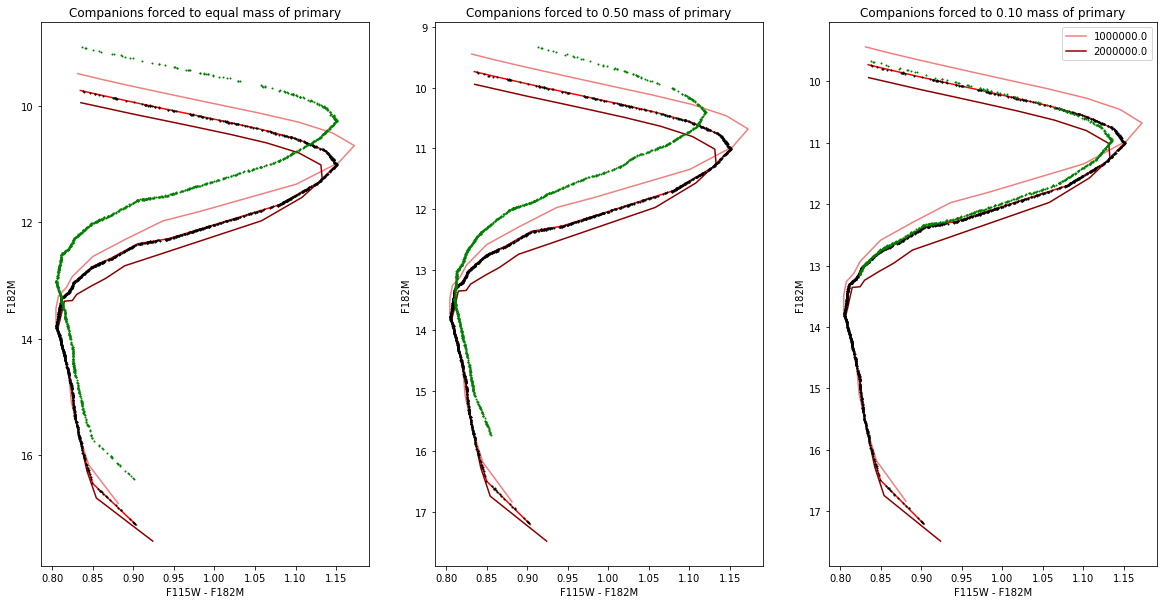

In [97]:
fig, axes = py.subplots(figsize=(20, 10))
# plot equal mass ratio CMD
py.subplot(1, 3, 1)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries1p0)):
    if unresolved_binaries1p0[i] is None:
        continue
    py.plot(unresolved_binaries1p0[i][0] - unresolved_binaries1p0[i][1], unresolved_binaries1p0[i][1], 
            marker='o', markersize=1, color='green')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to equal mass of primary')

py.subplot(1,3,2)
# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries0p5)):
    if unresolved_binaries0p5[i] is None:
        continue
    py.plot(unresolved_binaries0p5[i][0] - unresolved_binaries0p5[i][1], 
            unresolved_binaries0p5[i][1], marker='o', markersize=1, color='green')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to 0.50 mass of primary')

py.subplot(1,3,3)
# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
# plot unresolve binaries
for i in range(len(unresolved_binaries0p1)):
    if unresolved_binaries0p1[i] is None:
        continue
    py.plot(unresolved_binaries0p1[i][0] - unresolved_binaries0p1[i][1], 
            unresolved_binaries0p1[i][1], marker='o', markersize=1, color='green')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('Companions forced to 0.10 mass of primary')

py.legend()

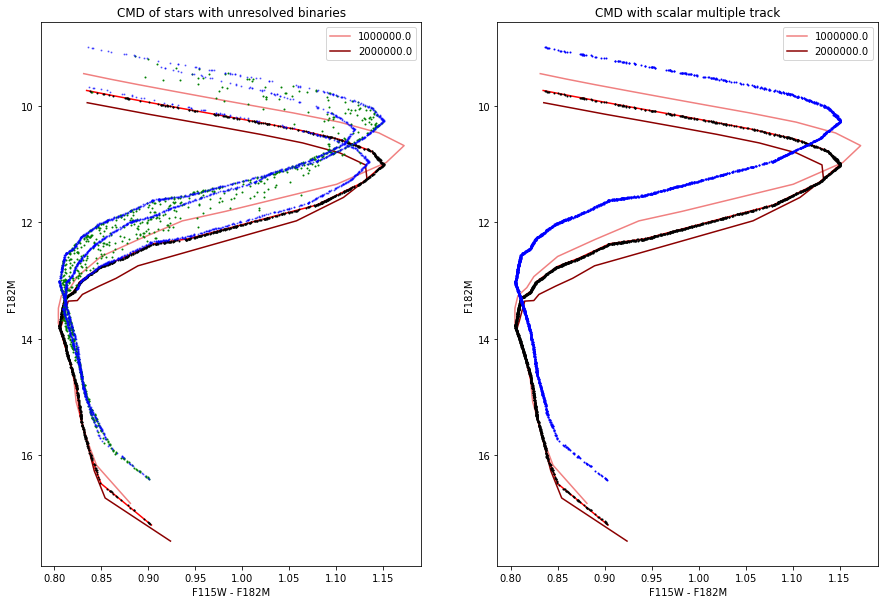

In [100]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of stars with unresolved binaries')
py.legend()

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='green')
    
for i in range(len(unresolved_binaries1p0)):
    if unresolved_binaries1p0[i] is None:
        continue
    py.plot(unresolved_binaries1p0[i][0] - unresolved_binaries1p0[i][1], unresolved_binaries1p0[i][1], 
            marker='o', markersize=1, color='blue', alpha=0.5)

for i in range(len(unresolved_binaries0p5)):
    if unresolved_binaries0p5[i] is None:
        continue
    py.plot(unresolved_binaries0p5[i][0] - unresolved_binaries0p5[i][1], 
            unresolved_binaries0p5[i][1], marker='o', markersize=1, color='blue', alpha=0.5)
    
for i in range(len(unresolved_binaries0p1)):
    if unresolved_binaries0p1[i] is None:
        continue
    py.plot(unresolved_binaries0p1[i][0] - unresolved_binaries0p1[i][1], 
            unresolved_binaries0p1[i][1], marker='o', markersize=1, color='blue', alpha=0.5)
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)

# plot isochrone curves
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')

# plot primary stars
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
# plot magnitude of each star if its flux was double
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='blue')

py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD with scalar multiple track')
py.legend()